# HySwash: A hybrid method for nearshore wave processes

Table of Contents
* [1. Clustering and selection method](#1.-Clustering-and-selection-method)
	* [1.1 LHS sampling](#1.1-LHS-sampling)
	* [1.2 MDA algorithm](#1.2-MDA-algorithm)<br><br>
    
* [2. Numerical model SWASH](#2.-Numerical-model-SWASH)
	* [2.1 Data preprocessing](#2.1-Data-preprocessing)   
		* [2.1.1 Cross-shore profile](#2.1.1-Cross-shore-profile)
		* [2.1.2 Friction](#2.1.2-Friction)     
		* [2.1.3 Vegetation](#2.1.3-Vegetation) 
	* [2.2. Boundary conditions](#2.2-Boundary-conditions)
		* [2.2.1 Sea state](#2.2.1-Sea-state)
		* [2.2.2 Wind](#2.2.2-Wind)
	* [2.3. Run](#2.3-Run)
	* [2.4. Data Postprocessing](#2.4.-Data-Postprocessing)<br><br>
    
* [3. Time series reconstruction RBF](#3.-Time-series-reconstruction-RBF)
<br><br>

In [1]:
import os
import os.path as op

import sys
sys.path.insert(0, op.join(os.getcwd(),'swash/hySwash/'))

## Latine Hypercube Sampling

In [2]:
from bluemath_tk.datamining.lhs import LHS

lhs_parameters = {
    'num_dimensions': 3,
    'num_samples': 10000,
    'dimensions_names': ['Hs', 'Hs_L0', 'plants'],
    'lower_bounds': [0.5, 0.005, 0],
    'upper_bounds': [3, 0.05, 3],
}

lhs = LHS(
    num_dimensions=lhs_parameters.get("num_dimensions"), 
    num_samples=lhs_parameters.get("num_samples"),
)
df_dataset = lhs.fit(
    dimensions_names=lhs_parameters.get("dimensions_names"),
    lower_bounds=lhs_parameters.get("lower_bounds"),
    upper_bounds=lhs_parameters.get("upper_bounds"),
)

## Clustering & Selection Method MDA

The high computational cost of propagating the entire hindcast dataset requires statistical tools to reduce the set of data to a number of representative cases to perform hybrid downscaling. The maximum dissimilarity algorithm (MDA) defined in the work of Camus et al., 2011, is implemented for this purpose.<br>
    <br>
Given a data sample $X=\{x_{1},x_{2},…,x_{N}\}$ consisting of $N$ $n$-dimensional vectors, a subset of $M$ vectors $\{v_{1},…,v_{M}\}$ representing the diversity of the data is obtained by applying this algorithm. The selection starts initializing the subset by transferring one vector from the data sample ${v1}$. The rest of the $M-1$ elements are selected iteratively, calculating the dissimilarity between each remaining data in the database and the elements of the subset and transferring the most dissimilar one to the subset. The process finishes when the algorithm reaches $M$ iterations.

In [3]:
from bluemath_tk.datamining.mda import MDA

mda_parameters = {
    'num_centers': 5
}

mda = MDA(num_centers=mda_parameters.get("num_centers"))
df_subset = mda.fit(data=df_dataset)

2024-11-08 12:12:51,044 - MDA - INFO - 
mda parameters: 10000 --> 5

2024-11-08 12:12:51,044 - MDA - INFO - 
mda parameters: 10000 --> 5

2024-11-08 12:12:51,045 - MDA - INFO - Normalizing data to range 0-1 using min max scaler approach
2024-11-08 12:12:51,045 - MDA - INFO - Normalizing data to range 0-1 using min max scaler approach
2024-11-08 12:12:51,049 - MDA - INFO -    MDA centroids: 2/5
2024-11-08 12:12:51,049 - MDA - INFO -    MDA centroids: 2/5
2024-11-08 12:12:51,051 - MDA - INFO -    MDA centroids: 3/5
2024-11-08 12:12:51,051 - MDA - INFO -    MDA centroids: 3/5
2024-11-08 12:12:51,052 - MDA - INFO -    MDA centroids: 4/5
2024-11-08 12:12:51,052 - MDA - INFO -    MDA centroids: 4/5
2024-11-08 12:12:51,053 - MDA - INFO -    MDA centroids: 5/5
2024-11-08 12:12:51,053 - MDA - INFO -    MDA centroids: 5/5


## Numerical model SWASH

In this section, the computational grid is defined from the bathymetric data and, optionally, wave dissipation characteristics due to the bottom friction or vegetation. The input grids will be considered uniform and rectangular, with the computational grid covering the whole bathymetric region.

In [4]:
# Build and Run cases

In [2]:
import numpy as np

from wrap_swash.wswash.wrap import SwashProject, SwashWrap, SwashIO
from wrap_swash.wswash.postprocessor import Postprocessor
from wrap_swash.wswash.plots import SwashPlot

p_proj = "/home/tausiaj/GitHub-GeoOcean/swash/hySwash/projects_valva/"
n_proj = p_proj + "test_valva/"

# Initialize the project
sp = SwashProject(p_proj, n_proj)
sw = SwashWrap(sp)
si = SwashIO(sp)
sm = SwashPlot(sp)

# Load the depth
depth = np.loadtxt('/home/tausiaj/GitHub-GeoOcean/swash/testcase/depth.bot')
sp.depth = depth
sp.b_grid.dx = 1            # bathymetry mesh resolution at x axes (m)
sp.dxL = 40                 # nº nodes per wavelength
sp.dxinp = 1                # bathymetry spacing resolution (m)
sp.dyinp = 1

# Set the simulation period and grid resolution
sp.tendc = 1800                          # simulation period (SEC)
sp.warmup = 0.15 * sp.tendc              # spin-up time (s) (default 15%)

# Postprocess SWASH output (raw to netCDF)
# sw.output_files()

# Define variables to compute
output_vars = ['Ru2', 'Msetup', 'RuDist', 'Hrms', 'Hfreqs']

# Initialize the postprocessor
pp = Postprocessor(sp, si, sw, output_vars=output_vars, run_post=False)

In [ ]:
# pp.ds_output.to_netcdf("../testcase/javi_output_example.nc")

## Cross-shore profile

Model boundaries should be far enough from the area of interest and away from steep topography to avoid unrealistic frictional or numerical dispersion effects but close enough to remain computationally feasible kh < 5. As a recommendation, the area of interest should be kept at least two wave lengths away from the boundary. In the following cells, different input choices for defining the cross-shore profile will be given. 
 
* `dxL`  : number of nodes per wavelength. This command sets the grid resolution from the number of nodes desired per wavelength in 1m depth (assuming that in the beach due to the infragravigity waves the water colum can reach 1m heigh). 

* `dxinp`: The resolution of the bathymetric grid is not the same as that of the computational grid. It is advised to avoid extremely steep bottom slopes or sharp obstacles as much as posible.

{'fontsize': 15, 'figure_width': 6.4, 'figure_height': 2.1333333333333333}


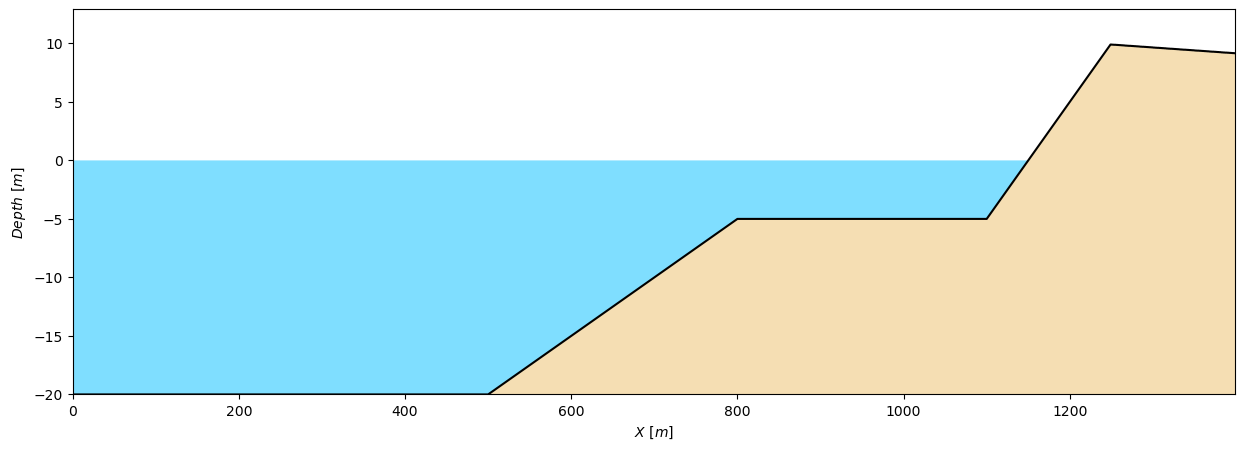

In [3]:
fig = sm.plot_depthfile()

In [26]:
from IPython.display import HTML

case = 0
ani = sm.animate_case_propagation(sp, case, tini=100, tend=200, tstep=4, figsize=(15,5))
HTML(ani.to_jshtml())

Range sigma 0.0010-0.1000 - Opt sigma 0.0679


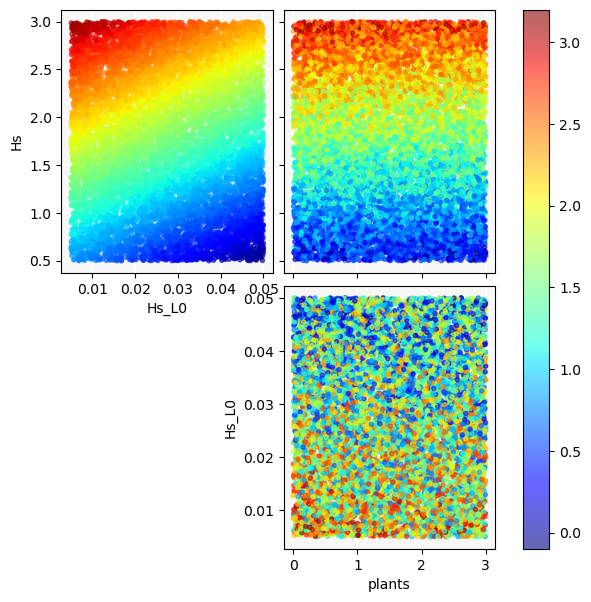

In [11]:
from lib.reconstruction import RBF_Reconstruction_singular
from lib.output_extract import scatter_color

# Sinular Reconstruction
var = ['Ru2']

ix_scalar_subset = [0, 1, 2]
ix_scalar_target = [0]
ix_directional_subset = []
ix_directional_target = []

# RBF reconstruction
df_output = RBF_Reconstruction_singular(
    pp, var, lhs_parameters.get("dimensions_names"), 
    df_dataset, df_subset,
    ix_scalar_subset, ix_directional_subset, 
    ix_scalar_target, ix_directional_target
)

fig = scatter_color(df_dataset, df_output, lhs_parameters.get("dimensions_names"), var, figsize=(7,7), vmin=None, vmax=None, cmap='jet')

Range sigma 0.0010-0.1000 - Opt sigma 0.0730
Range sigma 0.0010-0.1000 - Opt sigma 0.0379


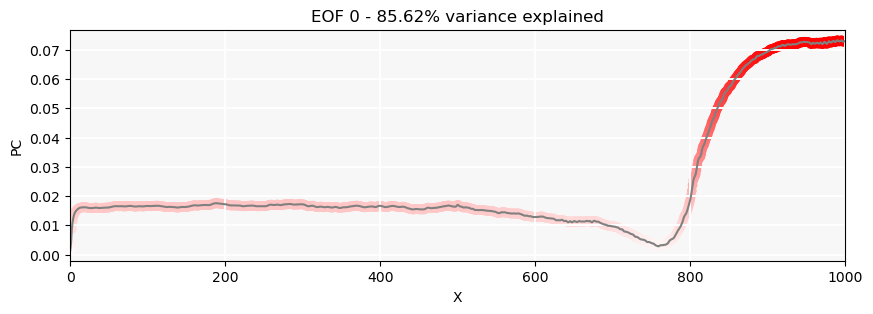

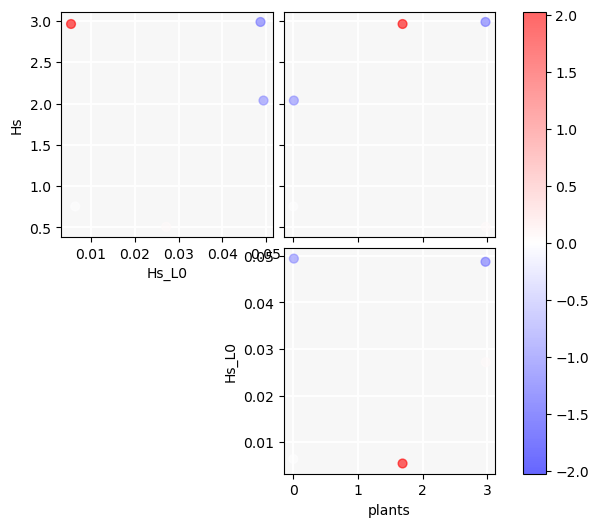

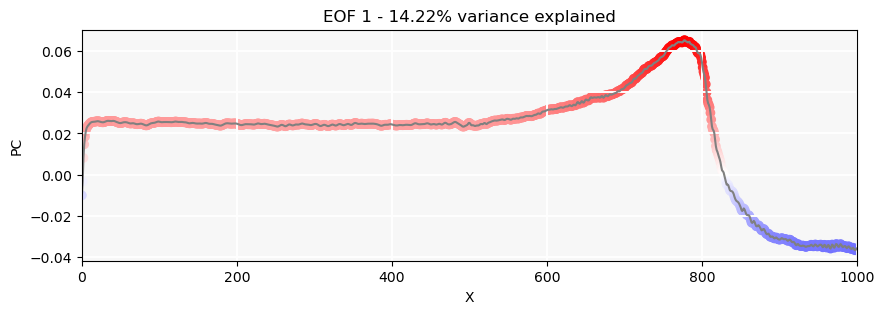

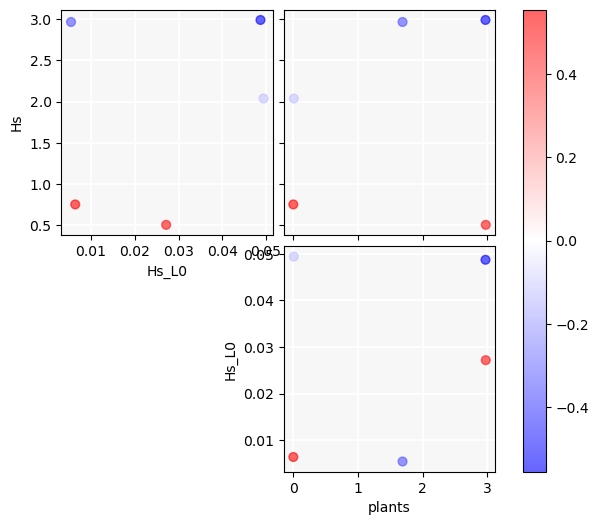

In [12]:
from lib.reconstruction import RBF_Reconstruction_spatial
from lib.PCA import plot_PCA

# Spatial Reconstruction
var = ['Msetup']                 # variable to reconstruct
X_max = 1000                     # maximum spatial X to consider for PCA
variance = 99                    # maximum variance to explain

ix_scalar_subset = [0, 1, 2]    
ix_scalar_target = [0]
ix_directional_subset = []
ix_directional_target = []

# Compute PCA and apply RBF recosntruction
xds_PCA, ds_output = RBF_Reconstruction_spatial(
    pp, var, lhs_parameters.get("dimensions_names"), 
    df_dataset, df_subset,
    ix_scalar_subset, ix_directional_subset, 
    ix_scalar_target, ix_directional_target, variance, X_max
)

plot_PCA(xds_PCA, df_subset, lhs_parameters.get("dimensions_names"), figsize1=(6+1,6), figsize2=(10,3))